In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Iteración 1: Modelo predictivo con datos de Ventas (VP Informe)

## Data Exploration para clustering

### Declaración de DataFrames globales

- **df_ventas_csv**: todo el fichero de VENTAS.TXT
- **df_compras_usuario_producto_agg**: agregado de numero de compras y e importe de ventas por usuario y producto, sobre el df_ventas_csv.
- **df_rfm**: extracción de variables rfm para df_ventas_csv,  filtrado para usuarios con 4 compras o más.
- **df_rfm_scaled**: escalado gaussiano de df_rfm.
- **df_labels**: dimension con los indices de los clusters, su descripción corta y larga.
- **df_rfm_with_label**: mezcla de df_rfm y df_labels. Contiene los IDs de los clientes utilizados para el RFM, así como la clase asignada.
- **df_clientes_csv**: todo el fichero de CLIENTES.TXT.
- **df_clientes_csv_rfm_with_label**: clientes de df_clientes_csv, filtrados a aquellos que se encuentran en  df_rfm_with_labels y a los que asignamos la clase.
- **df_sectores_csv**: todo el fichero SECTORES.TXT

### Carga de los ficheros y exploración básica

In [116]:
df_ventas_csv = pd.read_csv("data/VENTAS.TXT", sep="|", header=0)

In [117]:
df_ventas_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20537 entries, 0 to 20536
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                20537 non-null  int64 
 1   FECHAVENTA        20537 non-null  object
 2   PRODUCTOCOMPRADO  20537 non-null  object
 3   CANALVENTA        20537 non-null  object
 4   IMPORTE           20537 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 802.4+ KB


In [118]:
df_ventas_csv.head()

,ID,FECHAVENTA,PRODUCTOCOMPRADO,CANALVENTA,IMPORTE
0,6389279,21/3/2017 0:00:00,VP Informe,WEB,22
1,6389989,21/3/2017 0:00:00,VP Informe,WEB,15
2,6329507,1/2/2017 0:00:00,VP Informe,WEB,35
3,6326580,1/2/2017 0:00:00,VP Informe,WEB,22
4,6326580,1/2/2017 0:00:00,VP Informe,WEB,22


El fichero de compras tiene 4 variables:
- **ID**: Id único del cliente (numérico)
- **FECHAVENTA**: fecha de la venta (fecha)
- **PRODUCTOCOMPRADO**: el producto en concreto comprado (categorico)
- **CANALVENTA**: canal de la vetna (categórico)
- **IMPORTE**: importe de la venta (númerico)

**Expandimos variable de tipo fecha**

In [119]:
df_ventas_csv['FECHAVENTA'] = pd.to_datetime(df_ventas_csv['FECHAVENTA'], format='%d/%m/%Y %H:%M:%S')
df_ventas_csv['dia_venta'] = df_ventas_csv['FECHAVENTA'].dt.day
df_ventas_csv['mes_venta'] = df_ventas_csv['FECHAVENTA'].dt.month
df_ventas_csv['anio_venta'] = df_ventas_csv['FECHAVENTA'].dt.year

**Convertimos tipos y seteamos el index**

In [120]:
df_ventas_csv['ID'] = df_ventas_csv['ID'].astype(str).str.strip()

In [121]:
df_ventas_csv.describe()

,FECHAVENTA,IMPORTE,dia_venta,mes_venta,anio_venta
count,20537,20537.000000,20537.000000,20537.000000,20537.000000
mean,2020-08-05 08:30:44.086283264,77.900521,16.019867,6.578176,2020.090081
min,2017-01-02 00:00:00,6.000000,1.000000,1.000000,2017.000000
25%,2019-04-03 00:00:00,15.000000,8.000000,4.000000,2019.000000
50%,2020-10-14 00:00:00,35.000000,16.000000,7.000000,2020.000000
75%,2022-01-06 00:00:00,65.000000,24.000000,9.000000,2022.000000
max,2023-07-27 00:00:00,4875.000000,31.000000,12.000000,2023.000000
std,NaN,200.632042,8.719892,3.287639,1.708633


In [122]:
df_ventas_csv.select_dtypes(include='object').describe()

,ID,PRODUCTOCOMPRADO,CANALVENTA
count,20537,20537,20537
unique,9512,3,2
top,8125558,VP Informe,WEB
freq,173,18020,18478


In [123]:
print(df_ventas_csv.PRODUCTOCOMPRADO.unique())

['VP Informe' 'Plan' 'Bono']


In [124]:
print(df_ventas_csv.CANALVENTA.unique())

['WEB' 'CALLCENTER']


Búsqueda de Nulos

In [125]:
df_ventas_csv.isna().sum()

ID                  0
FECHAVENTA          0
PRODUCTOCOMPRADO    0
CANALVENTA          0
IMPORTE             0
dia_venta           0
mes_venta           0
anio_venta          0
dtype: int64

No hay nulos

### Análisis estadístico básico

**PRODUCTOCOMPRADO**

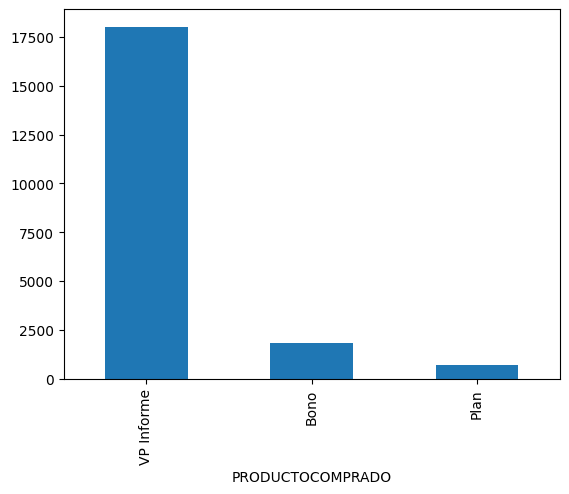

In [126]:
df_ventas_csv.PRODUCTOCOMPRADO.value_counts().plot(kind="bar");

- Se observa que el producto más vendido es, con diferencia, el **informe puntual**. Asumimos que los **bonos** y **planes** son más caros (ahora lo analizaremos) y por eso se venden menos, aunque deben representar a clientes más fieles. Aunque también puede suceder que tengamos clientes que gastan mucho en informes puntuales y que sean igual de fieles que los compradores de planes o bonos.

**Importe por producto**

**VP Informe**

In [127]:
df_ipp = df_ventas_csv[df_ventas_csv.PRODUCTOCOMPRADO=="VP Informe"]["IMPORTE"]
df_ipp.describe()

count    18020.000000
mean        33.923585
std         19.514838
min          6.000000
25%         15.000000
50%         35.000000
75%         40.000000
max        110.000000
Name: IMPORTE, dtype: float64

- Los informes varían entre 6 y 100 pesos de precio.

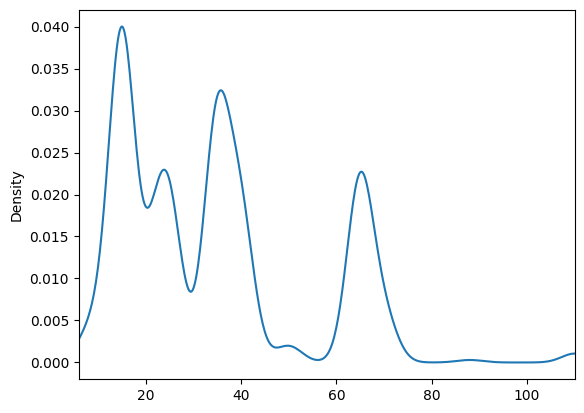

In [128]:
df_ipp.plot(kind="density", xlim=(df_ipp.min(),df_ipp.max()));

- El importe de las Ventas Puntuales de informe está sesgado hacia la izquierda. Los compradores tienen tendencia a comprar informes más económicos, aunque se aprecia una distribución multimodal, con varios picos. Puede que haya varios tipos de compradores de VP.

**Plan**

In [129]:
df_ipp = df_ventas_csv[df_ventas_csv.PRODUCTOCOMPRADO=="Plan"]["IMPORTE"]
df_ipp.describe()

count    710.000000
mean     322.804225
std       90.868508
min       69.000000
25%      252.000000
50%      330.000000
75%      414.000000
max      414.000000
Name: IMPORTE, dtype: float64

- Los planes varían entre 69 y 414 pesos

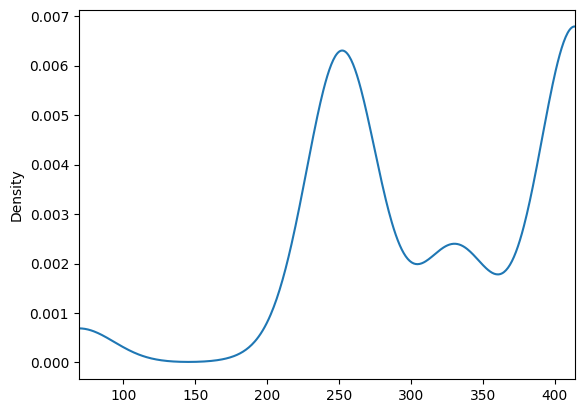

In [130]:
df_ipp.plot(kind="density", xlim=(df_ipp.min(),df_ipp.max()));

- La distribución de los importes de venta es claramente multimodal con un pico sobre los 250 y otro en los 400.

**Bono**

In [131]:
df_ipp = df_ventas_csv[df_ventas_csv.PRODUCTOCOMPRADO=="Bono"]["IMPORTE"]
df_ipp.describe()

count    1807.000000
mean      420.226342
std       539.026418
min        14.000000
25%       150.000000
50%       300.000000
75%       500.000000
max      4875.000000
Name: IMPORTE, dtype: float64

- Los precios de los bonos varían mucho, entre 14 pesos y 4875 pesos

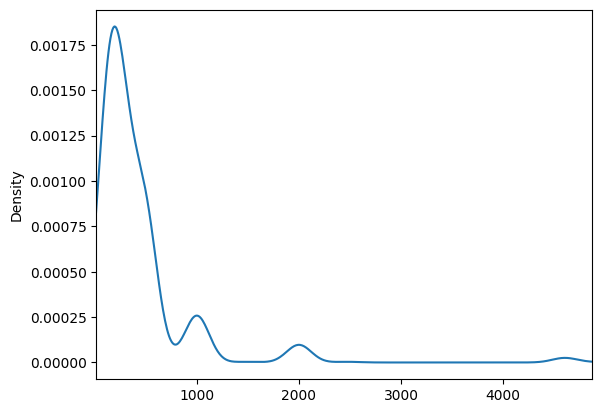

In [132]:
df_ipp.plot(kind="density", xlim=(df_ipp.min(),df_ipp.max()));

- Claramente, los compradores tienen tendencia a comprar bonos más enconómicos, aunque vemos algunos picos en bonos de mucho mayor importe (1000, 2000 e incluso por encima de 4000). También podemos tener distintos tipos de comprador de bonos.

**Comparativa de la distribución de los importes de venta de los tres productos**

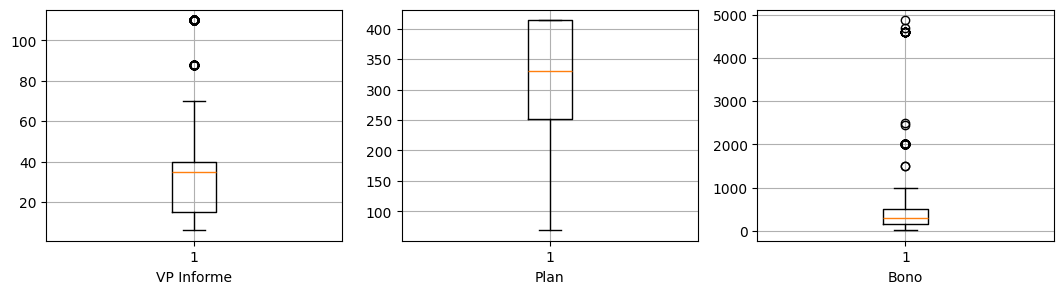

In [133]:
categories = df_ventas_csv["PRODUCTOCOMPRADO"].unique()

fig, axes = plt.subplots(nrows=1, ncols=len(categories), figsize=(13, 3), sharey=False)

for ax, category in zip(axes, categories):
    subset = df_ventas_csv[df_ventas_csv['PRODUCTOCOMPRADO']==category]
    ax.boxplot(subset['IMPORTE'])
    ax.set_xlabel(category)
    ax.grid(True)

Conclusiones
- La frecuencia y los rangos de venta de los productos son **muy distintos**.
- El comportamiento de los compradores de **Plan y Bono es más similiar**, salvo por los compradores de Bonos de muy alto precio.
- Los diferente tipología de producto hace que el **número de compras por usuario resulte ambiguo**, ya que un usuario que compra un plan de 400 pesos puede realizar sólo un pago, pero sin embargo, ser un cliente muy fiel por importe. **No podemos analizarlo conjuntamente**.
- Las distribuciones claramente **multimodales** de VP y Plan sugieren que tal vez hay diferentes grupos de compra en cada uno de ellos.

**CANALVENTA**

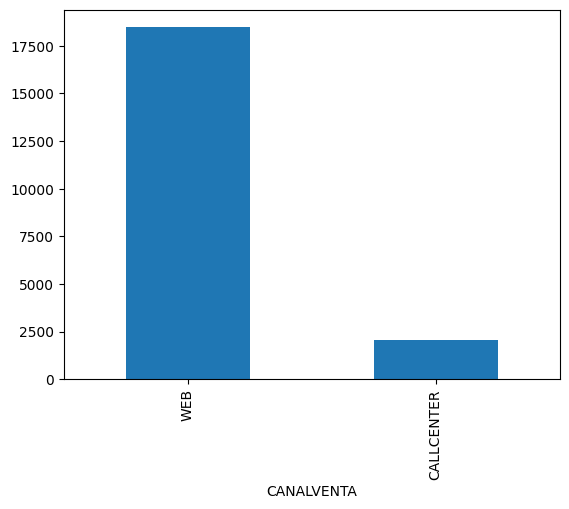

In [134]:
df_ventas_csv.CANALVENTA.value_counts().plot(kind="bar");

Histogramas

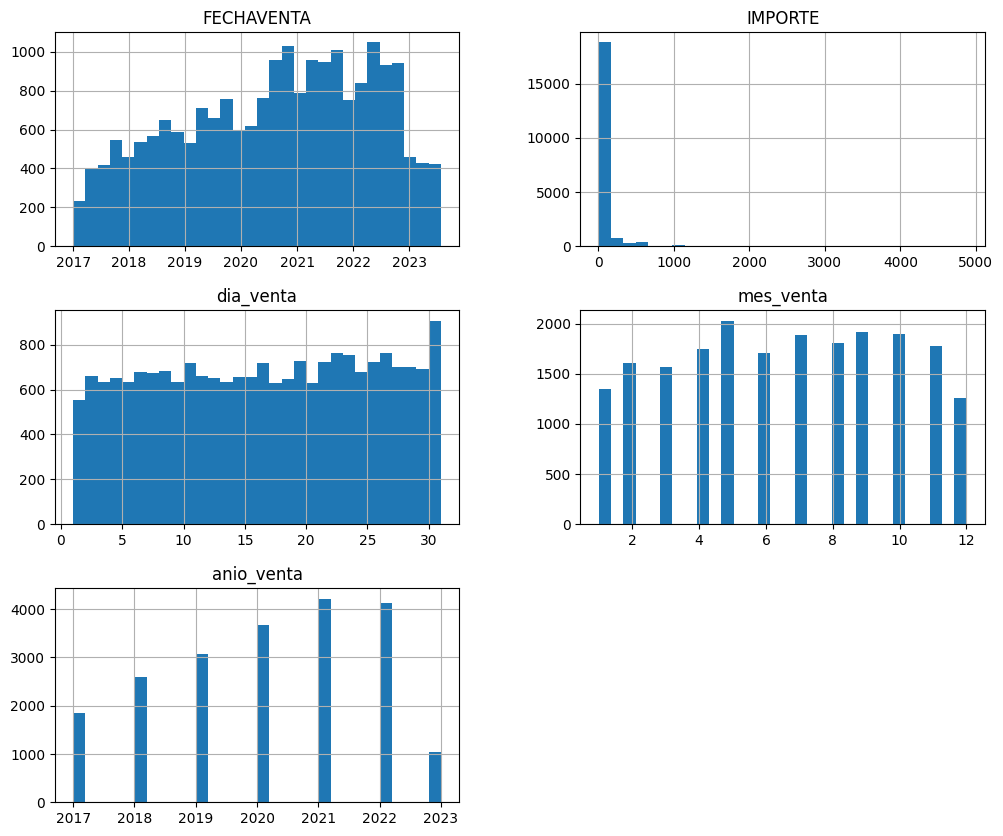

In [135]:
df_ventas_csv.hist(figsize=(12,10), bins=30);

- Sólo hay datos de ventas hasta julio 23.
- Las ventas han ido incrementando con los años
- No se aprecia patrón de venta sesgado por día o mes de venta, salvo que el día 31 hay un pico de ventas.

**Análisis de compras por usuario**

Tal y como hemos comentado en el análisis de "Compras por usuario", los tres grupos de productos tienen una tipología de compra muy diferente y vamos a analizarlos de manera separada.

Contruimos los datos

In [136]:
# Creamos el agregado por usuario y producto comprado
df_compras_usuario_producto_agg = df_ventas_csv.groupby(["ID","PRODUCTOCOMPRADO"]).agg(
        numero_compras=('ID', 'count'),
        total_importe_compra=('IMPORTE', 'sum')
    ).reset_index()

# Extraemos los tipos de producto
categories = df_compras_usuario_producto_agg["PRODUCTOCOMPRADO"].unique()

In [137]:
def plot_dist_compras_usuario(df, kpi, color):

    fig, axes = plt.subplots(nrows=1, ncols=len(categories), figsize=(9, 3), sharey=False)
    
    for i, ax in enumerate(axes):
        ax.hist(df[df["PRODUCTOCOMPRADO"]==categories[i]]
                [kpi], bins=30, color=color)
        ax.set_xlabel(categories[i])
        ax.grid(True)
    
    fig.suptitle(kpi);
    plt.tight_layout(rect=[0, 0, 1, 0.95])

**Distribución de los datos por Número de Compras**

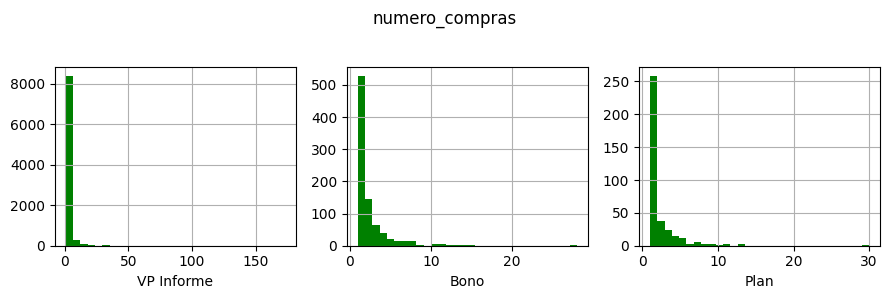

In [138]:
plot_dist_compras_usuario(df_compras_usuario_producto_agg, "numero_compras", "green")

- La distribución por número de compras es **similar** en los tres productos ya que se inclina hacia el 1.
- Sin embargo, parece que haya  **compras más repetitivas en los bonos y planes (cola por la derecha)**, implicando mayor grado de fidelización en estos productos.

Imprimimos el histograma de los datos, para verificar las impresiones visuales

In [139]:
def plot_hist(df, kpi):
    df_hist = pd.DataFrame(columns=(["min","25%", "50%", "75%", "90%", "95%", "99%", "max"]))

    for category in categories:
        p = df[df["PRODUCTOCOMPRADO"]==category][kpi]\
            .describe(percentiles=[.25, .5, .75, .90, .95, .99])
        df_hist.loc[category] = (p["min"], p["25%"], p["50%"], p["75%"], p["90%"], p["95%"], p["99%"], p["max"])

    return df_hist

In [140]:
plot_hist(df_compras_usuario_producto_agg, "numero_compras")

,min,25%,50%,75%,90%,95%,99%,max
VP Informe,1.0,1.0,1.0,2.0,4.0,6.0,14.0,173.0
Bono,1.0,1.0,1.0,2.0,4.0,7.0,11.0,28.0
Plan,1.0,1.0,1.0,2.0,4.0,6.0,11.0,30.0


- Nos estaba engañando la escala de los gráficos. La distribución del número de compras es prácticamente igual en los tres productos, salvo por los máximos en VP Informe

**Distribución de los datos por Total Importe de Compra**

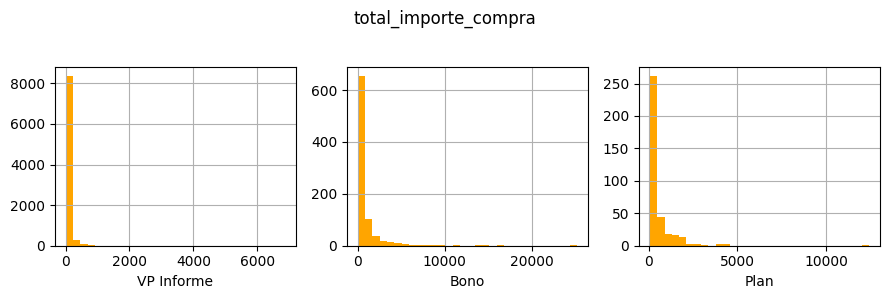

In [141]:
plot_dist_compras_usuario(df_compras_usuario_producto_agg, "total_importe_compra", "orange")

- De nuevo, los tres productos tienen a la mayoría de las compras en importes bajos.
- Sin embargo, vemos de nuevo en bonos y planes algo de tendencia a comprar con importes superiores dentro de cada categoría.

Imprimimos el histograma de los datos, para verificar las impresiones visuales

In [142]:
plot_hist(df_compras_usuario_producto_agg, "total_importe_compra")

,min,25%,50%,75%,90%,95%,99%,max
VP Informe,6.0,15.0,35.0,70.0,140.0,220.0,530.60,6865.0
Bono,14.0,150.0,300.0,800.0,2000.0,3450.0,8400.00,25200.0
Plan,69.0,252.0,414.0,582.0,1455.0,1885.5,4130.25,12420.0


- Podemos verificar parcialmente lo visualizado. En los VPs, el mínimo (6) y el 50% (35) son 5 veces más; sin embargo, en Bono, el mínimo (14) y el 50% (300) está a 20 veces. En Planes no pasa lo mismo, el 50% (414) es tan sólo 6 veces más que el mínimo (69)

### Análisis de atípicos

In [143]:
def get_outliers_metadata(df, category):

    outlier_metadata = pd.DataFrame(columns=["Q1", "Q3", "IQR", "upper_bound", "total_outliers", "perc_outliers"])

    subset = df[df["PRODUCTOCOMPRADO"]==category]
    
    for columna in ("numero_compras", "total_importe_compra"):
    
        # Cálculo de cuartiles y límite de outliers
        Q1 = subset[columna].quantile(0.25)
        Q3 = subset[columna].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + (1.5 * IQR)
    
        # Obtención de los atípicos
        total_outliers = subset[subset[columna]>upper_bound].shape[0]
        perc_outliers = round(total_outliers/subset.shape[0]*100,1)
    
        outlier_metadata.loc[columna] = (Q1, Q3, IQR, upper_bound, total_outliers, perc_outliers)

    return outlier_metadata

**VP Informe**

In [144]:
outliers = get_outliers_metadata(df_compras_usuario_producto_agg, "VP Informe")

outliers

,Q1,Q3,IQR,upper_bound,total_outliers,perc_outliers
numero_compras,1.0,2.0,1.0,3.5,981.0,11.2
total_importe_compra,15.0,70.0,55.0,152.5,755.0,8.6


- Según la distribución de compras, los usuarios que han comprado más de 3 veces son atípicos. Y si han gastado más de 152.5 pesos también. 
- El porcentaje de atípicos ronda el 10%

**Plan**

In [145]:
outliers = get_outliers_metadata(df_compras_usuario_producto_agg, "Plan")

outliers

,Q1,Q3,IQR,upper_bound,total_outliers,perc_outliers
numero_compras,1.0,2.0,1.0,3.5,46.0,12.6
total_importe_compra,252.0,582.0,330.0,1077.0,53.0,14.5


- Según la distribución de compras, los usuarios que han comprado más de 3 veces son atípicos (igual que en los VPs). Y si han gastado más de 1077 pesos también.
- El porcentaje de atípicos ronda el 13%

**Bonos**

In [146]:
outliers = get_outliers_metadata(df_compras_usuario_producto_agg, "Bono")

outliers

,Q1,Q3,IQR,upper_bound,total_outliers,perc_outliers
numero_compras,1.0,2.0,1.0,3.5,123.0,14.3
total_importe_compra,150.0,800.0,650.0,1775.0,99.0,11.5


- De nuevo, los usuarios que han comprado más de 3 veces son atípicos. Este patrón se repite en los tres tipos de productos. El comportamiento es muy homogeneo.
- En el límite de gasto para ser atípico, los bonos son muy semejantes a los Planes.
- El porcentaje de atípicos es muy similar en los tres productos.

**Análisis visual de atípicos**

In [147]:
def print_outlier_visual_analysis(df, kpi):

    categories = df["PRODUCTOCOMPRADO"].unique()
    
    fig, axes = plt.subplots(nrows=1, ncols=len(categories), figsize=(13, 3), sharey=False)
    
    for ax, category in zip(axes, categories):
        subset = df[df['PRODUCTOCOMPRADO']==category]
        ax.boxplot(subset[kpi])
        ax.set_xlabel(category)
        ax.grid(True)
    
    fig.suptitle(kpi)

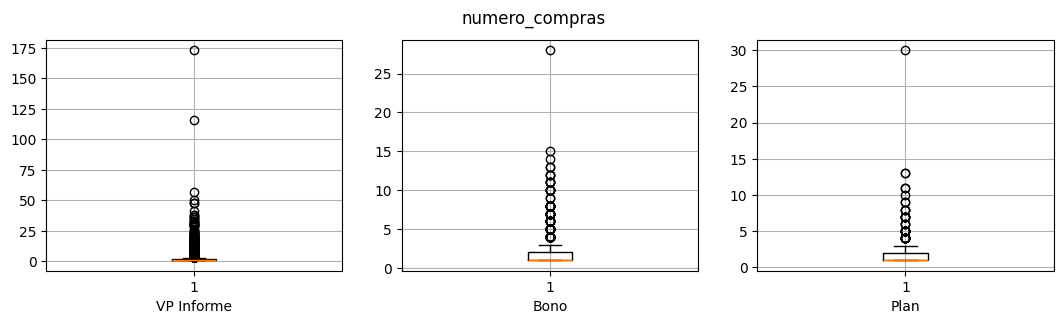

In [148]:
print_outlier_visual_analysis(df_compras_usuario_producto_agg, 'numero_compras')

Por número de compras, ya sabíamos que la mayoría de los compradores repiten poco. Sin embargo, los repetidores en los tres productos no parecen datos erroneos. 

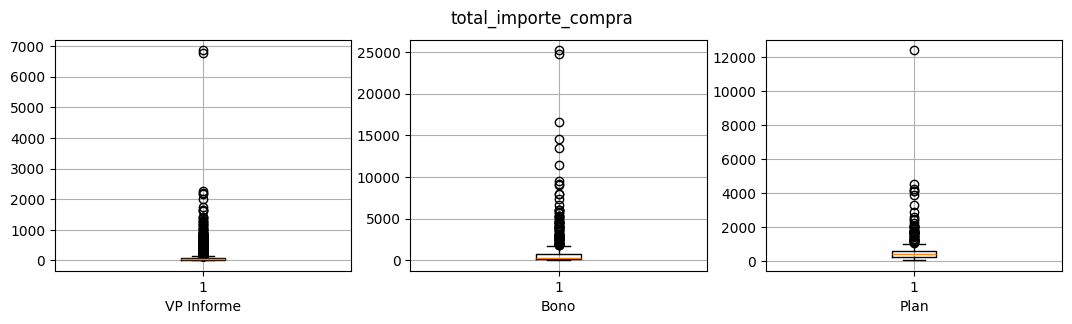

In [149]:
print_outlier_visual_analysis(df_compras_usuario_producto_agg, 'total_importe_compra')

- Para VPs, se ven datos muy alejados. Podría ser sospecho. Aunque al ser varios compradores, no apunta a dato erroneo.
- Para Planes pasa lo mismo, pero no parecen varios datos. Lo revisaremos.
- En Bono no se aprecia un patrón de datos erroneos.

Revisión de atípicos de Planes

In [150]:
df_planes =  df_compras_usuario_producto_agg[df_compras_usuario_producto_agg['PRODUCTOCOMPRADO']=="Plan"]["total_importe_compra"]

#Filtramos para el percetil 99 de atípicos de Planes
df_planes_outlier = df_planes[df_planes>4130.25]

df_planes_outlier.sort_values()

2835     4140
3074     4263
1464     4554
578     12420
Name: total_importe_compra, dtype: int64

Hay un único dato especialmente elevado. Habrá que tenerlo presente por si fuera un error de datos

## Modelo no supervisado

Como ya hemos determinado en el análisis estadístico, la distribución de compras es muy diferente en los tres tipos de productos. Esto nos ha llevado a realizar un análisis individual de cada tipo de compra. No podemos comparar la fidelidad de un cliente que gasta mucho dinero en un bono que compra una vez, con un ciente que también compra una sola vez, pero que lo hace de un informe puntual.

Por este motivo, el cálculo de variables RFM y posterior clusterización, se va a realizar por productos separados.

In [151]:
producto_análisis = "VP Informe"

### Cálculo de variables RFM

Las variables RFM corresponen a los valores:
- **Recency**: Cuán reciente fue la última compra del cliente.
- **Frecuency**: La frecuencia de compra de un cliente en un periodo determinado.
- **Monetary**: El valor monetario de esas compras en el periodo.

En nuestro caso de estudio, tenemos datos de ventas de clientes desde 2017 hasta mitad de 2023. De cara a segementar los clientes, vamos a tratar las variables de la siguiente forma:
- **Recency**: *número de días desde la última compra realizada*.
- **Frecuency**: *media del tiempo entre compras*. Es decir, de media, cada cuanto compra el cliente, en días. Por ejemplo, un cliente realiza de media compras cada 30 días. Los clientes con compras más frecuentes pueden ser más valiosos.
- **Monetary**: *media del importe de compra*. Utilizamos la media en lugar de la mediana para detectar clientes que normalmente compran importes bajos pero que, puntalmente, realizan una compra muy eleveda. Este valor va a aumentar la media y destacará en un grupo de mayor consumo.

In [152]:
def get_frequency(x):
    '''
    Obtiene la frecuencia de una serie de valores, según nuestra definición.
    Ordena los valores de menor a mayor y calcula la distancia entre cada valor, añadiendo
    previamente un 0 por delante, para marcar el inicio de datos
    Por ejemplo [90, 30] se ordenaria como [0, 30, 90] y  obtendía una lista de [30, 60]
    Por último, calcula la media de las distancias para calcular el tiempo medio entre
    compras
    '''

    # Ordenamos la lista de dias desde la compra
    valores = sorted(x.tolist())

    # añadimos un cero, para tomar como referencia el último día de datos 
    valores = [0] + valores
    
    return np.diff(valores).mean()

# Obtiene los valores de RMF de un df, para una categoría de producto
def get_rfm(df, category, drop_num_compras):
    '''
    df: El dataframe original con los datos de ventas
    category: el tipo de producto por el que filtrar (VP Informe, Plan, Bono)
    drop_num_compras: número mínimo de compras realizadas por un usuario para no ser filtrado
    '''

    # Filtramos para el producto deseado 
    #subset = df[df['PRODUCTOCOMPRADO']==category]
    subset = df

    # Agrupamos compras del mismo usuario, el mismo día
    df_usuario_dia = subset.groupby(["ID","FECHAVENTA"]).agg(IMPORTE=("IMPORTE","sum")).reset_index()

    # Calculamos la última fecha a la que tenemos datos de compras
    max_fecha_data = df_usuario_dia["FECHAVENTA"].max()

    # Calculamos los días desde la última compra de cada compra, para poder calcular el tiempo medio entre compras (frecuencia)
    df_usuario_dia["dias_desde_ultima_compra"] = df_usuario_dia["FECHAVENTA"].map( lambda x: (max_fecha_data - x).days)
    
    df_rfm = df_usuario_dia.groupby("ID").agg(
        recency=("dias_desde_ultima_compra", "min"),
        frequency=("dias_desde_ultima_compra",lambda x: get_frequency(x)),
        suma_importe=("IMPORTE","sum"),
        num_compras=("ID","count")
    )

    # Cálculo del valor monetario
    df_rfm["monetary"] = df_rfm["suma_importe"] / df_rfm["num_compras"]

    # Filtro los clientes por numero de compras
    df_rfm = df_rfm[df_rfm["num_compras"]>=drop_num_compras]

    # Limpiamos las columnas de cálculo
    df_rfm = df_rfm.drop(columns=["suma_importe", "num_compras"])

    return df_rfm

Obtenemos los datos de RFM sin eliminar ningún cliente (filtro número de compras mínimo es 0)

In [153]:
df_rfm = get_rfm(df_ventas_csv, producto_análisis , 0)

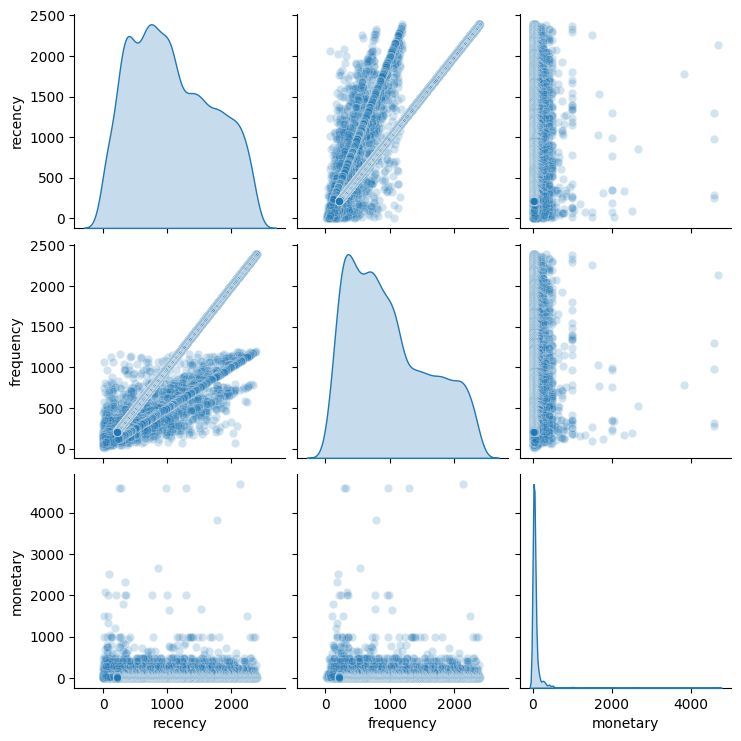

In [154]:
sns.pairplot(df_rfm, kind="scatter", diag_kind="kde",  plot_kws={'alpha': 0.2});

- Al revisar el cálculo RFM, apreciamos que se pueden ver grandes diagonales en la relación entre frecuencia y recencia. Esto es debido a que el 75% de los clientes sólo han comprado dos veces o menos. En esos casos, la recencia y la frecuencia se asemejan mucho y tan poco obtenemos un conocimiento real del comportamiento del cliente.
- Según el análisis de atípicos, los clientes que han comprado más de 3 veces son atípicos. Vamos a utilizar esta medida para separar los cientes que aún no vamos a estudiar por tener un número bajo de compras, de aquellos que ya tienen un comportamiento más normalizado.
- Para ello, filtramos el RFM para clientes con 4 o más compras. Esto valor coincide con el percentil 90% de los datos.

In [155]:
df_rfm = get_rfm(df_ventas_csv, producto_análisis, 1)

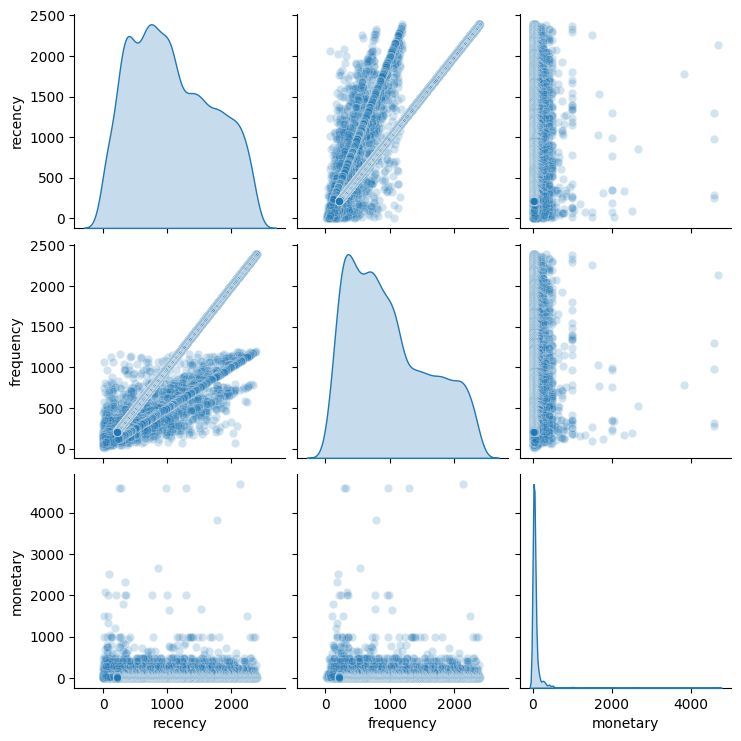

In [156]:
sns.pairplot(df_rfm, kind="scatter", diag_kind="kde",  plot_kws={'alpha': 0.2});

- Se sigue apreciando una correlación entre frecuencia y recencia, pero no tan extrame como en el gráfico anterior.
- La nube de puntos de monetary con las otras variables es mucho más interpretable y podemos apreciar zonas de calor, que nos van dando pistas de posibles segmentos.

### Cluster Kmeans

In [157]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

**Escalado**

- Escalamos las variables para que todas se encuentren bajo la misma escala y el cálculo de distancias no se vea influenciado por los diferentes rangos.
- Vamos a utilizar normalización Gaussiana, dato que mantiene correctamente las proporciones de las variables.


In [158]:
# Función para visualizar los grupos FM en 2D
def plot_fm_2D_cluster(df, x, y, labels):
    plt.figure(figsize=(5, 3))
    ax = plt.scatter(x=df[x], y=df[y], c=labels, marker='o', alpha=.3);

    plt.xlabel(x)
    plt.ylabel(y);

In [159]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [160]:
standar_scaler = StandardScaler()
rfm_scaled = standar_scaler.fit_transform(df_rfm)
df_rfm_scaled = pd.DataFrame(rfm_scaled, columns=df_rfm.columns)

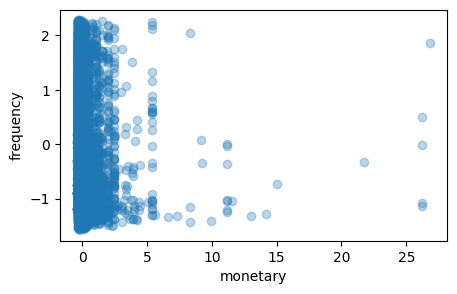

In [161]:
plot_fm_2D_cluster(df_rfm_scaled, "monetary", "frequency", None)

Para asegurarnos de que el escalado elegido es el correcto, vamos a visualizar los datos con el escalado MinMax, que transforma la escala de cada variable a (0,1)

In [162]:
min_max_scaler = MinMaxScaler()
rfm_scaled_test = min_max_scaler.fit_transform(df_rfm)
df_rfm_scaled_test = pd.DataFrame(rfm_scaled_test, columns=df_rfm.columns)

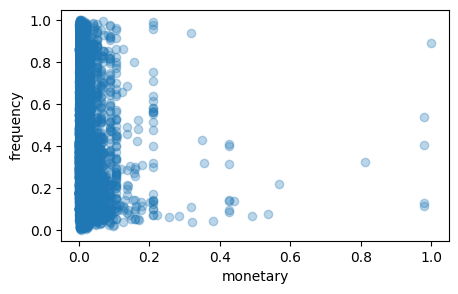

In [163]:
plot_fm_2D_cluster(df_rfm_scaled_test, "monetary", "frequency", None)

- Podemos observar el escalado MinMax ha deformado la relación de las variables. Para los valores de Monetary, que tiene algunos más extremos, éstos han quedado incluidos dentreo de la escala (0,1) y por lo tanto, las distancias entre los puntos del nucleo van a quedar más acortadas, cuando las comparemos con las de frequency.

**Cálculo del número optimo de clusters**

##### Método del codo

In [164]:
df_rfm_scaled = df_rfm_scaled[["frequency","monetary"]]

In [165]:
inertia= []
max_clusters = 20
for i in range(1,max_clusters):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(df_rfm_scaled)
    inertia.append(kmeans.inertia_)

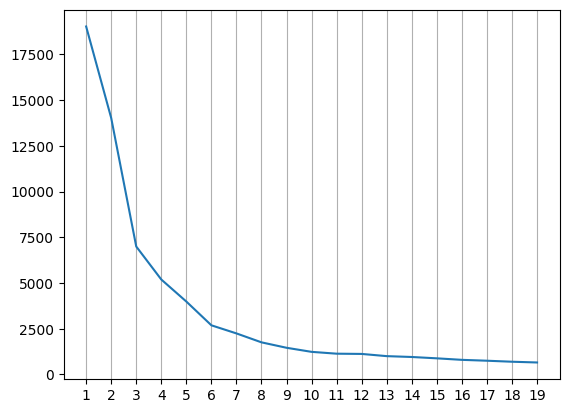

In [166]:
plt.plot(range(1,max_clusters), inertia);
plt.xticks(ticks=np.arange(1, max_clusters));
#plt.xlim(left=2)
plt.grid(axis="x");

Visulamente, el número correcto aparenta estar entre 2 y 5 clusters, aunque parece haber un codo también en el 8.

##### Análisis Silhouette

In [255]:
from sklearn.metrics import silhouette_score, silhouette_samples

def analisis_silhouette(max_clusters):

    s_score = []
    
    for n in range(2,max_clusters+1):
    
        cluster_labels = KMeans(n_clusters=n, random_state=42).fit_predict(df_rfm_scaled)
        
        # Average silhouette score
        silhouette_avg = silhouette_score(df_rfm_scaled, cluster_labels)
        
        s_score.append(silhouette_avg)
    
    plt.xticks(ticks=np.arange(2, max_clusters+1));
    plt.plot(range(2,max_clusters+1),s_score);

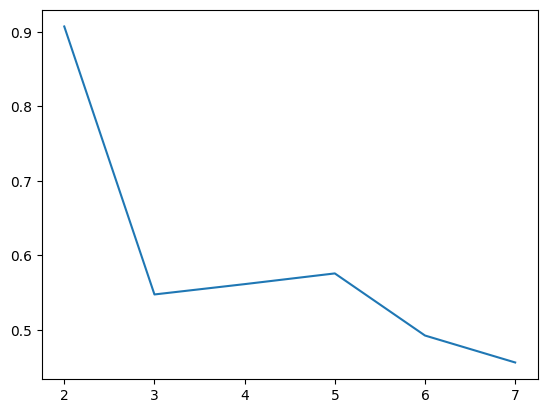

In [256]:
analisis_silhouette(7)

Analizando el valor de silhouette, vemos que la mejor separación la optenemos con 2, 4 y 5 grupos.

El **analisis silhouette** ofrece una visualización **más precisa** que el método del codo. Se observan mejor los puntos de mejora de las métricas de clusterización

**Visualizamos para K=2, K=4 y K=5**

In [257]:
cluster_labels_3 = KMeans(n_clusters=3, random_state=42).fit_predict(df_rfm_scaled)
cluster_labels_4 = KMeans(n_clusters=4, random_state=42).fit_predict(df_rfm_scaled)
cluster_labels_5 = KMeans(n_clusters=5, random_state=42).fit_predict(df_rfm_scaled)

In [258]:
def print_RFM_subplots(df, labels):
    
    features = (("monetary", "frequency"), ("monetary", "recency"))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 3), sharey=False)

    for ax, feature in zip(axes, features):

        ax.scatter(x=df[feature[0]], y=df[feature[1]], c=labels, marker='o', alpha=.3);
        
        ax.set_xlabel(feature[0])
        ax.set_ylabel(feature[1])

**K=2**

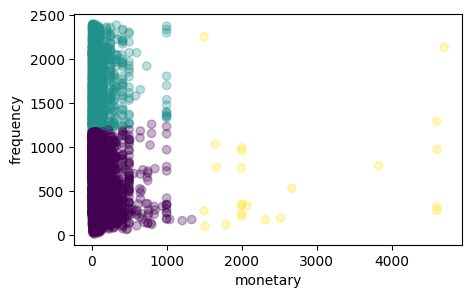

In [259]:
plot_fm_2D_cluster(df_rfm, "monetary", "frequency", cluster_labels_3)

Con dos grupos, el algoritmo divide a la población por mayoritariamente por frecuencia de compra (gráfico izquierda) y por recencia (gráfico derecha). Esta segmentación parece mejorable, ya que el valor monetaraio de los clientes debería tenerse más en cuenta.

**K=4**

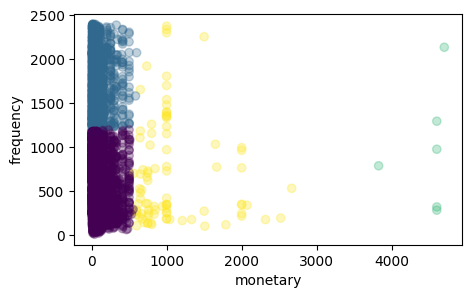

In [260]:
plot_fm_2D_cluster(df_rfm, "monetary", "frequency", cluster_labels_4)

Al pasar a cuatro grupos, ya sí distinguimos la división por valor monetario. Vamos a analizar los grupos partiendo del gráfico FM (Frequency vs Monetary):
- Vemos un grupo claramente indentificado de valor monetario medio y alta frecuencia (cluster azul). Este grupo también se observa bien diferenciado en el gráfico RM (Recency vs Monetary). Son clientes con compras recientes. Podríamos llamar a este grupo **clientes habituales**.
- El grupo morado identifica a los clientes de valor monetario medio y  baja frecuencia. Gastan como el grupo azul ("clientes habituales"), pero con menos frecuencia de compra. ¿No necesitan tanto nuestros servicios? ¿Son empresas más pequeñas? ¿Cómo podemos aumentar su frecuencia de compra?. Lo llamaremos **clientes puntuales**
- El grupo verde contiene el mismo tipo de cliente que el grupo morado, pero captura algunos clientes de valor monetario más alto. Estos dos grupos tienen una gran intersección debido a que se diferencian en la recencia: el grupo morado ha realizado compras más recientes. El grupo verde pueden ser **clientes puntuales de baja recencia**, que hace tiempo que no compran. Tal vez estén en riesgo de dejar de utilizar nuestros servicios.
- Por último, el grupo amarillo nos identifica clientes de valor monetario alto y frecuencias alta y media. Podrían ser nuestros **clientes premium**. Hay que destacar que en este grupo están mezclados clientes de diferentes frecuencias y tal vez se pudiera subdivir aún más, en clientes premium y ultra premium (para los clientes de muy alta frecuencia). Los clientes de valor monetario alto pero baja frecuencia quedaron capturados en el grupo verde.

**K=5**

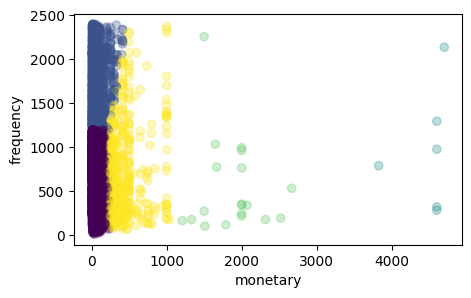

In [261]:
plot_fm_2D_cluster(df_rfm, "monetary", "frequency", cluster_labels_5)

- Al pasar a 5 grupos, ganamos en la diferención del segmento de valor monetario alto, que queda identificado en un mismo grupo (verde clarito), sin importar ni la frecuencia, ni la recencia. Es probablemente la mayor diferencia entre la clusterizaciones de 4 y 5 grupos
- Tendríamos que preguntarnos si nos interesa hacer esta diferencian en nuestras estratégias de marketing. ¿El grupo de valor monetario alto es suficientemente especial, como para tratarlo por separado, sin importar la frecuencia ni la recencia? 

**Conclusiones**

- El análisis RFM es realmente útil a la hora de dividir los segmentos de clientes y poder enfocar las estratégisas de marketing.
- Según el enfoque del negocio, podremos elegir el número de grupos de la clusterización.
- El análisis silhouette es una herramienta realmente poderosa a la hora de encontrar el número ideal de grupos.
- La elección del método de escalado de los datos es crítico a la hora de la clusterización. Si no se elige bien, se pueden desvirtuar los análisis.

## Data Exploration para el modelo predictivo

Finalmente, voy a utilizar la clusterización con 4 grupos, para probar los modelos predictivos. Esta es una decisión que deberían hacer los equipos de negocio, según el resultado de los segmentos y las estrategías de marketing a seguir.

El etiquetado de los clientes para entrenar el modelo predictivo será el siguiente:
- **clientes habituales** (valor moneterio medio, alta frecuencia y alta recencia)
- **clientes puntuales** (valor moneterio medio, baja frecuencia y alta recencia)
- **clientes puntuales de baja recencia** (valor moneterio medio, baja frecuencia y baja recencia)
- **clientes premium** (valor moneterio medio, frecuencia alta y media y recencia alta y media)

#### Construcción de etiquetas

In [174]:
df_labels = pd.DataFrame(columns=["class","class_desc","class_desc_short"]).set_index("class")

In [274]:
def print_RFM_subplots_with_highlight(df, labels, highlight):
    '''
    Función que destaca uno de los clusters
    '''
    
    plt.figure(figsize=(5,3))

    index_highlight = labels == highlight

    plt.scatter(x=df.loc[index_highlight,"monetary"], y=df.loc[index_highlight, "frequency"], marker='o', alpha=.3);
    plt.scatter(x=df.loc[~index_highlight,"monetary"], y=df.loc[~index_highlight, "frequency"], marker='o', alpha=.3);
    plt.xlabel("monetary")
    plt.ylabel("frequency")

##### Grupo 0 - clientes puntuales

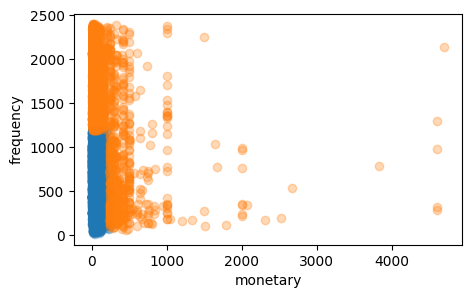

In [300]:
print_RFM_subplots_with_highlight(df_rfm, cluster_labels_5, 0)

In [301]:
df_labels.loc[0] = ("clientes habituales","CH")

##### Grupo 1 - clientes habituales

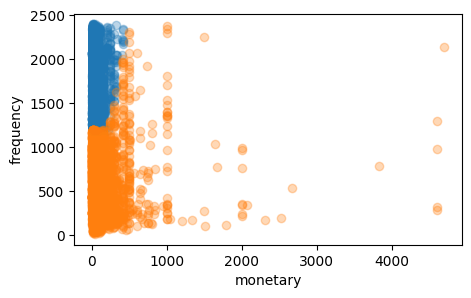

In [302]:
print_RFM_subplots_with_highlight(df_rfm, cluster_labels_5, 1)

In [303]:
df_labels.loc[1] = ("clientes habituales baja frecuancia","CHBF")

##### Grupo 2 - clientes puntuales de baja recencia

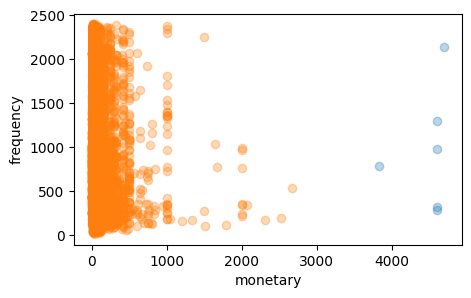

In [304]:
print_RFM_subplots_with_highlight(df_rfm, cluster_labels_5, 2)

In [305]:
df_labels.loc[2] = ("clientes premium superior","CPREMSUM")

##### Grupo 3 - clientes premium

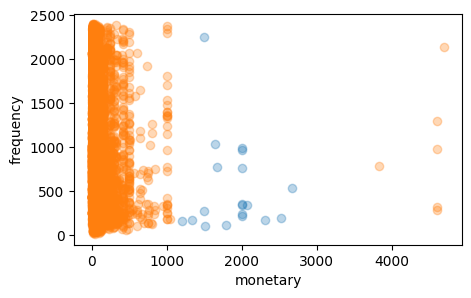

In [306]:
print_RFM_subplots_with_highlight(df_rfm, cluster_labels_5, 3)

In [307]:
df_labels.loc[3] = ("clientes premium","CPREM")

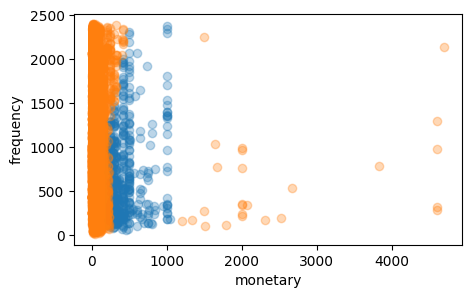

In [308]:
print_RFM_subplots_with_highlight(df_rfm, cluster_labels_5, 4)

In [309]:
df_labels.loc[4] = ("clientes superior","CSUP")

Añadimos las etiquetas a los clientes segmentados y lo mezclamos con el df de descripción de etiquetas

In [310]:
df_rfm["class"] = cluster_labels_5
df_rfm_with_label = df_rfm.join(df_labels, on="class", how="inner")

df_rfm_with_label.head()

,recency,frequency,monetary,class,class_desc,class_desc_short
ID,,,,,,
6308943,2397,2397.000,21.000,1,clientes habituales baja frecuancia,CHBF
6309102,2388,2388.000,22.000,1,clientes habituales baja frecuancia,CHBF
6309127,222,299.625,31.875,0,clientes habituales,CH
6309222,1343,293.800,30.000,0,clientes habituales,CH
6309425,2396,2396.000,15.000,1,clientes habituales baja frecuancia,CHBF


In [311]:
df_labels

,class_desc,class_desc_short
class,,
0,clientes habituales,CH
1,clientes habituales baja frecuancia,CHBF
2,clientes premium superior,CPREMSUM
3,clientes premium,CPREM
4,clientes superior,CSUP


Vamos a visualizar el número de clientes por clase

In [312]:
unique_values, counts = np.unique(df_rfm_with_label["class"], return_counts=True)

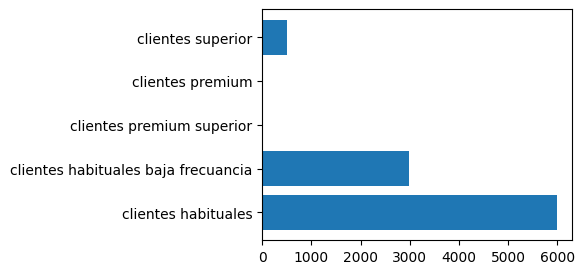

In [313]:
plt.figure(figsize=(4, 3)) 
plt.barh(df_labels["class_desc"],counts);

- Las clases están desbalanceadas. Cuando tengamos todas las features para predicción seleccionadas, tendremos que realizar oversampling.

### Carga de los ficheros y exploración básica

In [314]:
df_clientes_csv = pd.read_csv("data/CLIENTES.TXT", sep="|", header=0)

**Transformación de tipos y set index**

In [315]:
df_clientes_csv['ID'] = df_clientes_csv['ID'].astype(str).str.strip()
df_clientes_csv = df_clientes_csv.set_index("ID")
df_clientes_csv['FECHA_REGISTRO'] = pd.to_datetime(df_clientes_csv['FECHA_REGISTRO'], format='%d/%m/%Y %H:%M:%S')
df_clientes_csv['FECHA_CLIENTE'] = pd.to_datetime(df_clientes_csv['FECHA_CLIENTE'], format='%d/%m/%Y %H:%M:%S')

In [316]:
df_clientes_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9512 entries, 6384286 to 9650613
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   FECHA_REGISTRO          9512 non-null   datetime64[ns]
 1   CANAL_REGISTRO          9512 non-null   object        
 2   FECHA_CLIENTE           9512 non-null   datetime64[ns]
 3   CLIENTEPORCAMPAÑAEMAIL  9512 non-null   int64         
 4   FORMAJURIDICA           9512 non-null   object        
 5   SECTOR                  9512 non-null   object        
 6   DESC_SECTOR             9512 non-null   object        
 7   ESTADO                  9512 non-null   object        
 8   DEPARTAMENTO            3912 non-null   object        
 9   TAMAÑO                  3912 non-null   object        
 10  ANTIGUEDAD              3912 non-null   object        
 11  DIASCLIENTE             9512 non-null   int64         
 12  CONSUMOSTOTAL           9512 non-null   int6

In [317]:
df_clientes_csv.head()

,FECHA_REGISTRO,CANAL_REGISTRO,FECHA_CLIENTE,CLIENTEPORCAMPAÑAEMAIL,FORMAJURIDICA,SECTOR,DESC_SECTOR,ESTADO,DEPARTAMENTO,TAMAÑO,ANTIGUEDAD,DIASCLIENTE,CONSUMOSTOTAL,EMPRESASUNICAS_CONSULT,NUM_COMPRAS,IMPORTE_COMPRAS
ID,,,,,,,,,,,,,,,,
6384286,2017-03-15 15:24:29,WEB,2017-03-15 15:36:22,0,PERSONA FISICA,9,NOSECTOR,VIVA,NaN,NaN,NaN,0,11,3,1,35
6384667,2017-03-15 19:18:31,WEB,2018-03-08 11:01:32,0,SOCIEDAD,K,ACTIVIDADES FINANCIERAS Y DE SEGUROS,ACTIVA,BOGOTA,MICRO,De 5 a 10 Años,358,1,1,1,15
6389279,2017-03-21 11:39:08,WEB,2017-03-21 11:39:11,0,SOCIEDAD,N,ACTIVIDADES DE SERVICIOS ADMINISTRATIVOS Y DE ...,ACTIVA,BOLIVAR,PEQUEÑA,Más de 10 Años,0,75,36,38,904
6387954,2017-03-18 19:47:34,Directorios,2017-05-24 22:05:19,0,PERSONA FISICA,9,NOSECTOR,VIVA,NaN,NaN,NaN,67,61,10,13,684
6383269,2017-03-15 06:58:58,Directorios,2017-03-15 07:07:12,0,PERSONA FISICA,9,NOSECTOR,VIVA,NaN,NaN,NaN,0,1,1,1,22


**Filtramos los clientes categorizados en el RFM y les asignamos la clase**

In [318]:
df_clientes_csv_rfm_with_label = df_clientes_csv.join(df_rfm_with_label[["class","class_desc_short"]], how="inner")

In [319]:
df_clientes_csv_rfm_with_label.head()

,FECHA_REGISTRO,CANAL_REGISTRO,FECHA_CLIENTE,CLIENTEPORCAMPAÑAEMAIL,FORMAJURIDICA,SECTOR,DESC_SECTOR,ESTADO,DEPARTAMENTO,TAMAÑO,ANTIGUEDAD,DIASCLIENTE,CONSUMOSTOTAL,EMPRESASUNICAS_CONSULT,NUM_COMPRAS,IMPORTE_COMPRAS,class,class_desc_short
ID,,,,,,,,,,,,,,,,,,
6384286,2017-03-15 15:24:29,WEB,2017-03-15 15:36:22,0,PERSONA FISICA,9,NOSECTOR,VIVA,NaN,NaN,NaN,0,11,3,1,35,1,CHBF
6384667,2017-03-15 19:18:31,WEB,2018-03-08 11:01:32,0,SOCIEDAD,K,ACTIVIDADES FINANCIERAS Y DE SEGUROS,ACTIVA,BOGOTA,MICRO,De 5 a 10 Años,358,1,1,1,15,1,CHBF
6389279,2017-03-21 11:39:08,WEB,2017-03-21 11:39:11,0,SOCIEDAD,N,ACTIVIDADES DE SERVICIOS ADMINISTRATIVOS Y DE ...,ACTIVA,BOLIVAR,PEQUEÑA,Más de 10 Años,0,75,36,38,904,0,CH
6387954,2017-03-18 19:47:34,Directorios,2017-05-24 22:05:19,0,PERSONA FISICA,9,NOSECTOR,VIVA,NaN,NaN,NaN,67,61,10,13,684,0,CH
6383269,2017-03-15 06:58:58,Directorios,2017-03-15 07:07:12,0,PERSONA FISICA,9,NOSECTOR,VIVA,NaN,NaN,NaN,0,1,1,1,22,1,CHBF


**Check nulos**

In [320]:
df_clientes_csv_rfm_with_label.isna().sum()

FECHA_REGISTRO               0
CANAL_REGISTRO               0
FECHA_CLIENTE                0
CLIENTEPORCAMPAÑAEMAIL       0
FORMAJURIDICA                0
SECTOR                       0
DESC_SECTOR                  0
ESTADO                       0
DEPARTAMENTO              5600
TAMAÑO                    5600
ANTIGUEDAD                5600
DIASCLIENTE                  0
CONSUMOSTOTAL                0
EMPRESASUNICAS_CONSULT       0
NUM_COMPRAS                  0
IMPORTE_COMPRAS              0
class                        0
class_desc_short             0
dtype: int64

Solo encontramos nulos en DEPARTAMENTO, TAMAÑO y ANTIGUEDAD. Los trataremos individualmente.

**FECHA_REGISTRO**
- Fecha en la que se registra el usuario en la web. No tiene por qué ser en la que se convierte en cliente: realiza una compra.

In [321]:
print(df_clientes_csv_rfm_with_label["FECHA_REGISTRO"].min())
print(df_clientes_csv_rfm_with_label["FECHA_REGISTRO"].max())

2017-01-02 14:22:16
2022-12-30 11:17:41


- No se observan valores fuera de rango. Variable OK.

**CANAL_REGISTRO**
- Canal por el que fue captado el usuario

In [322]:
df_clientes_csv_rfm_with_label["CANAL_REGISTRO"].value_counts()

CANAL_REGISTRO
Directorios    4859
WEB            3690
SEM             963
Name: count, dtype: int64

- No se observan valores extraños. Variable OK

**FECHA_CLIENTE**
- Fecha de la primera compra

In [323]:
print(df_clientes_csv_rfm_with_label["FECHA_REGISTRO"].min())
print(df_clientes_csv_rfm_with_label["FECHA_REGISTRO"].max())

2017-01-02 14:22:16
2022-12-30 11:17:41


- No se observan valores fuera de rango. Variable OK.
- Los valores son coherentes con la FECHA_REGISTRO. El mínimo de fecha cliente es igual al de fecha registro. Sucede igual con el máximo.

**CLIENTEPORCAMPAÑAEMAIL**

1 - Compró por una Campaña de Email

In [324]:
df_clientes_csv_rfm_with_label["CLIENTEPORCAMPAÑAEMAIL"].value_counts()

CLIENTEPORCAMPAÑAEMAIL
0    8717
1     795
Name: count, dtype: int64

- El 9% de los clientes compró por una campaña de email

**FORMAJURIDICA**
- Forma Societaria de la Empresa/Persona:
    - ADMINISTRACION
    - EMBAJADAS Y ORGANISMOS INTERNACIONALES
    - EMPRESARIO
    - ESAL, Empresa sin Ánimo de Lucro
    - PERSONA FISICA que no tiene sociedad ni es empresario
    - SOCIEDAD Colombiana, SAS, SA, LTDA, etc.
    - SOCIEDAD EXTRANJERA cuya matriz es extranjera

In [325]:
df_clientes_csv_rfm_with_label["FORMAJURIDICA"].value_counts()

FORMAJURIDICA
PERSONA FISICA                            5600
SOCIEDAD                                  2515
EMPRESARIO                                1270
ESAL                                        86
SOCIEDAD EXTRANJERA                         38
ADMINISTRACION                               2
EMBAJADAS Y ORGANISMOS INTERNACIONALES       1
Name: count, dtype: int64

- No se observan valores extraños. Los valores con coherentes con lo esperado.
- Más de la mitad de los compradores son personas físicas.

**SECTOR**
- Letra del Sector de Actividad

In [326]:
df_clientes_csv_rfm_with_label["SECTOR"].value_counts()

SECTOR
9    5600
G    1109
M     603
C     535
J     268
N     232
F     202
H     155
I     150
K     136
L     106
S      87
Q      66
Z      47
A      43
P      41
R      41
E      31
B      30
D      20
O       7
T       2
U       1
Name: count, dtype: int64

- No se observan valores extraños.

**DESC_SECTOR**

In [327]:
frecuencias = df_clientes_csv_rfm_with_label["DESC_SECTOR"].str[:100].value_counts()
porcentajes = (frecuencias / len(df_clientes_csv_rfm_with_label)) * 100
porcentajes

DESC_SECTOR
NOSECTOR                                                                                                58.873003
COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACIÓN DE VEHÍCULOS AUTOMOTORES Y MOTOCICLETAS                11.658957
ACTIVIDADES PROFESIONALES, CIENTÍFICAS Y TÉCNICAS                                                        6.339361
INDUSTRIAS MANUFACTURERAS                                                                                5.624474
INFORMACIÓN Y COMUNICACIONES                                                                             2.817494
ACTIVIDADES DE SERVICIOS ADMINISTRATIVOS Y DE APOYO                                                      2.439024
CONSTRUCCIÓN                                                                                             2.123633
TRANSPORTE Y ALMACENAMIENTO                                                                              1.629521
ALOJAMIENTO Y SERVICIOS DE COMIDA                                           

- El valor predominante "NOSECTOR" coincide con el número de personas físicas y representa casi el 44% de la población.,
- El sector más representado para las personas jurídicas es "COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACIÓN DE VEHÍCULOS AUTOMOTORES Y MOTOCICLETAS", seguido de "ACTIVIDADES PROFESIONALES, CIENTÍFICAS Y TÉCNICAS" e "INDUSTRIAS MANUFACTURERAS".

- Como los textos son muy largos, utilizaremos la variable SECTOR para clasificar. Para mostrar la descripción posteriormente, utilizaremos la dimensión DESC_SECTOR del fichero "SECTORES.TXT"

In [328]:
df_sectores_csv = pd.read_csv("data/SECTORES.TXT", sep="|", header=0)

In [329]:
df_sectores_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   SECTOR       23 non-null     object
 1   DESC_SECTOR  23 non-null     object
dtypes: object(2)
memory usage: 496.0+ bytes


In [330]:
df_sectores_csv.head()

,SECTOR,DESC_SECTOR
0,9,NOSECTOR
1,A,"AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y P..."
2,B,EXPLOTACIÓN DE MINAS Y CANTERAS
3,C,INDUSTRIAS MANUFACTURERAS
4,D,"SUMINISTRO DE ELECTRICIDAD, GAS, VAPOR Y AIRE ..."


check cruce

In [331]:
df_clientes_csv_rfm_with_label.merge(df_sectores_csv, on="SECTOR", how="inner").shape

(9512, 19)

- Obtenemos los mismos clientes. No se descarta ninguno por no cruzar y no se generan duplicados. Dimensión OK.

In [332]:
df_sectores_csv["DESC_SECTOR"].str[:100].value_counts()

DESC_SECTOR
NOSECTOR                                                                                                1
ACTIVIDADES INMOBILIARIAS                                                                               1
ACTIVIDADES DE ORGANIZACIONES Y ENTIDADES EXTRATERRITORIALES                                            1
ACTIVIDADES DE LOS HOGARES INDIVIDUALES EN CALIDAD DE EMPLEADORES; ACTIVIDADES NO DIFERENCIADAS DE L    1
OTRAS ACTIVIDADES DE SERVICIOS                                                                          1
ACTIVIDADES ARTÍSTICAS, DE ENTRETENIMIENTO Y RECREACIÓN                                                 1
ACTIVIDADES DE ATENCIÓN DE LA SALUD HUMANA Y DE ASISTENCIA SOCIAL                                       1
EDUCACIÓN                                                                                               1
ADMINISTRACIÓN PÚBLICA Y DEFENSA; PLANES DE SEGURIDAD SOCIAL DE AFILIACIÓN OBLIGATORIA                  1
ACTIVIDADES DE SERVICIOS ADMINISTR

- Los textos parecen OK

**ESTADO**

Situación de la Persona/Empresa:
- ACTIVA
- EXTINGUIDA
- INACTIVA
- INSOLVENTE
- VIVA (solo Personas Físicas)

In [333]:
df_clientes_csv_rfm_with_label["ESTADO"].value_counts()

ESTADO
VIVA          5600
ACTIVA        3091
INACTIVA       718
EXTINGUIDA      57
INSOLVENTE      46
Name: count, dtype: int64

- No se observan valores extraños
- El valor VIVA coincide con las personas físicas.

**DEPARTAMENTO**

Departamento de Colombia donde reside.

In [334]:
df_clientes_csv_rfm_with_label["DEPARTAMENTO"].value_counts(dropna=False)

DEPARTAMENTO
NaN                5600
BOGOTA             1951
ANTIOQUIA           647
VALLE               290
CUNDINAMARCA        216
ATLANTICO           176
SANTANDER           127
BOLIVAR              68
RISARALDA            59
CALDAS               45
META                 37
NORTE SANTANDER      35
NARINO               34
TOLIMA               32
MAGDALENA            28
BOYACA               23
HUILA                23
CORDOBA              21
QUINDIO              20
CESAR                16
CAUCA                13
CASANARE              9
SUCRE                 9
CAQUETA               7
LA GUAJIRA            7
ARAUCA                4
CHOCO                 4
SAN ANDRES            3
PUTUMAYO              3
GUAVIARE              2
FUERA DEL PAIS        2
AMAZONAS              1
Name: count, dtype: int64

- Se observan los NaN identificados previamente. Los demás datos parecen OK.
- Las personas físicas coinciden con los NaN.
- El departamente con más clientes es BOGOTA. Tiene sentido porque es la capital.

In [335]:
df_clientes_csv_rfm_with_label["DEPARTAMENTO"] = df_clientes_csv_rfm_with_label["DEPARTAMENTO"].fillna("VACIO")

**TAMAÑO**

Tamaño de la Sociedad(no Personas Físicas):
- GRANDE
- MEDIANA
- MICRO
- PEQUEÑA
- SIN DETERMINAR

In [336]:
df_clientes_csv_rfm_with_label["TAMAÑO"].value_counts(dropna=False)

TAMAÑO
NaN               5600
MICRO             1745
PEQUEÑA            968
MEDIANA            722
GRANDE             410
SIN DETERMINAR      67
Name: count, dtype: int64

- Se observan los NaN identificados previamente. Los demás datos parecen OK.
- Las personas físicas coinciden con los NaN.
- La mayoría de los clientes empresa son de tipo MICRO y continuan en orden ascendente.


In [337]:
df_clientes_csv_rfm_with_label["TAMAÑO"] = df_clientes_csv_rfm_with_label["TAMAÑO"].fillna("VACIO")

**ANTIGUEDAD**

Antigüedad de la Sociedad(no Personas Físicas):
- Menos de 3 Meses
- De 3 a 18 Meses
- De 18 Meses a 3 Años
- De 3 a 5 Años
- De 5 a 10 Años
- Más de 10 Años
- SIN FECHA DE CONSTITUCION

In [338]:
df_clientes_csv_rfm_with_label["ANTIGUEDAD"].value_counts(dropna=False)

ANTIGUEDAD
NaN                          5600
Más de 10 Años               2491
De 5 a 10 Años                962
De 3 a 5 Años                 275
De 18 Meses a 3 Años          118
De 3 a 18 Meses                48
SIN FECHA DE CONSTITUCION      12
Menos de 3 Meses                6
Name: count, dtype: int64

- Se observan los NaN identificados previamente. Los demás datos parecen OK.
- Las personas físicas coinciden con los NaN.
- La mayoría de los clientes empresa tienen más de 10 años de antiguedad como empresa. ¿Las empresas con más experiencia son las que consumen este tipo de servicios?

In [339]:
df_clientes_csv_rfm_with_label["ANTIGUEDAD"] = df_clientes_csv_rfm_with_label["ANTIGUEDAD"].fillna("VACIO")

**DIASCLIENTE**

Días transcurridos desde la Fecha de Registro hasta la Fecha de cliente

In [340]:
df_clientes_csv_rfm_with_label["DIASCLIENTE"].describe()

count    9512.000000
mean       99.390349
std       270.228371
min         0.000000
25%         0.000000
50%         0.000000
75%        19.000000
max      2103.000000
Name: DIASCLIENTE, dtype: float64

Check días cliente

In [341]:
dias_cliente = df_clientes_csv_rfm_with_label["FECHA_CLIENTE"] - df_clientes_csv_rfm_with_label["FECHA_REGISTRO"]

In [342]:
dias_cliente.describe()

count                           9512
mean      99 days 09:29:30.662531539
std      270 days 05:19:28.684169128
min                  0 days 00:00:00
25%                  0 days 00:06:29
50%           0 days 00:32:17.500000
75%                 18 days 22:02:45
max               2102 days 18:33:10
dtype: object

- La variable está OK, con un gran sesgo hacia el cero. La mayoría de clientes se registra y compra el mismo día.

**CONSUMOSTOTAL**

Número de Consumos/Consultas

In [343]:
df_clientes_csv_rfm_with_label["CONSUMOSTOTAL"].describe()

count      9512.000000
mean        101.617536
std        4102.038989
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max      371738.000000
Name: CONSUMOSTOTAL, dtype: float64

- Varible OK

In [344]:
df_clientes_csv.columns

Index(['FECHA_REGISTRO', 'CANAL_REGISTRO', 'FECHA_CLIENTE',
       'CLIENTEPORCAMPAÑAEMAIL', 'FORMAJURIDICA', 'SECTOR', 'DESC_SECTOR',
       'ESTADO', 'DEPARTAMENTO', 'TAMAÑO', 'ANTIGUEDAD', 'DIASCLIENTE',
       'CONSUMOSTOTAL', 'EMPRESASUNICAS_CONSULT', 'NUM_COMPRAS',
       'IMPORTE_COMPRAS'],
      dtype='object')

**EMPRESASUNICAS_CONSULT**

Número de empresas consultadas

In [345]:
df_clientes_csv_rfm_with_label["EMPRESASUNICAS_CONSULT"].describe()

count      9512.000000
mean         50.528070
std        1728.142542
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max      154069.000000
Name: EMPRESASUNICAS_CONSULT, dtype: float64

- Variable OK

**NUM_COMPRAS**

Numero de Compras/Ventas

In [346]:
df_clientes_csv_rfm_with_label["NUM_COMPRAS"].describe()

count    9512.000000
mean        2.159062
std         3.719538
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       173.000000
Name: NUM_COMPRAS, dtype: float64

- El mínimo concuerda con el filtro de "mínimo 4 compras" para entrar en el análisis RFM.

**IMPORTE_COMPRAS**

Importe de las compras

In [347]:
df_clientes_csv_rfm_with_label["IMPORTE_COMPRAS"].describe()

count     9512.000000
mean       168.192073
std        682.529480
min          6.000000
25%         22.000000
50%         40.000000
75%        100.000000
max      25200.000000
Name: IMPORTE_COMPRAS, dtype: float64

Check con el fichero de ventas, filtrado para los cliente del RFM y sumando los importes comprados

In [348]:
df_ventas_csv.set_index("ID").join(df_rfm,how="inner").groupby("ID").agg(total_importe=("IMPORTE","sum")).describe()

,total_importe
count,9512.000000
mean,168.192073
std,682.529480
min,6.000000
25%,22.000000
50%,40.000000
75%,100.000000
max,25200.000000


- Encaja perfectamente.

### Selección de características

**Variables numéricas**

**Matriz de correlación**

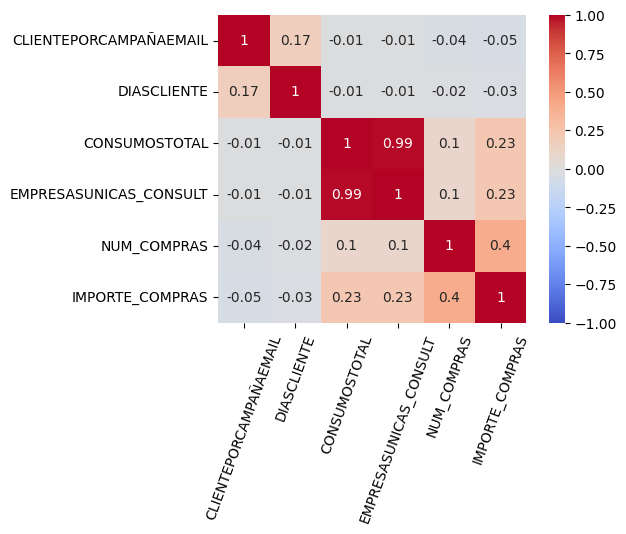

In [349]:
corr_matrix = df_clientes_csv_rfm_with_label.drop(["class"], axis=1).corr(numeric_only=True).round(2)
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True,vmin=-1, vmax=1)
plt.xticks(rotation=70);

- CLIENTEPORCAMPAÑAEMAIL no tienen correlación con ninguna variable.
- DIASCLIENTE tampoco.
- Las variables derivadas del consumo y compra (CONSUMOSTOTAL, EMPRESASUNICAS_CONSULT, NUM_COMPRAS e IMPORTE_COMPRAS) están correlacionadas como era de esperar.
- A priori, vamos a descartar EMPRESASUNICAS_CONSULT por tener una correlación de 0.91 con CONSUMOSTOTAL.
- Tal vez descartemos también IMPORTE_COMPRAS por tener mucha correlación (0.7) con CONSUMOSTOTAL.

**PCA**

In [350]:
from sklearn.decomposition import PCA

In [351]:
#seleccionar columnas numéricas
df_numeric_columns = df_clientes_csv_rfm_with_label.drop(["class"], axis=1).select_dtypes(include=['number'])
df_numeric_columns.head()

,CLIENTEPORCAMPAÑAEMAIL,DIASCLIENTE,CONSUMOSTOTAL,EMPRESASUNICAS_CONSULT,NUM_COMPRAS,IMPORTE_COMPRAS
ID,,,,,,
6384286,0,0,11,3,1,35
6384667,0,358,1,1,1,15
6389279,0,0,75,36,38,904
6387954,0,67,61,10,13,684
6383269,0,0,1,1,1,22


In [352]:
# Escalado y PCAz
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric_columns)

pca = PCA()
pca.fit(scaled_data);

df_pca = pd.DataFrame(pca.components_, columns=df_numeric_columns.columns)

df_pca["varianza"] =  pca.explained_variance_ratio_

df_pca = df_pca.apply(lambda x: round(x,2))

Visualización PCA

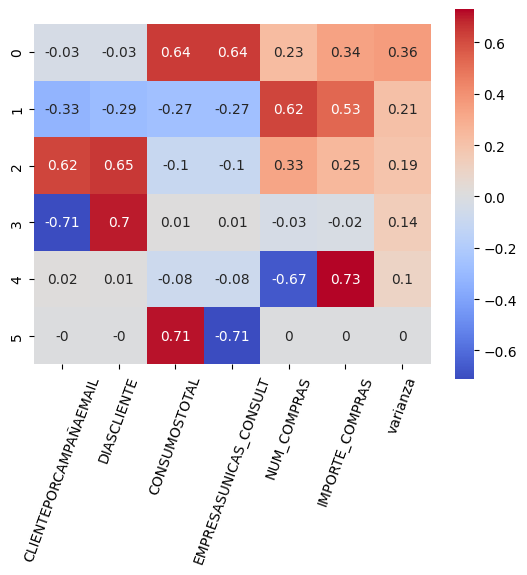

In [353]:
sns.heatmap(df_pca, annot=True, cmap='coolwarm',  square=True)
plt.xticks(rotation=70);

- Los 4 primeros componentes explican el 94% de la varianza de los datos. Descartamos el análisis de los dos últimos
- Se puede observar que hay dos grupos de variables diferenciados:
    - En el primer componente (49% de la varianza), destacan las 4 variables relacionadas con las compras y el consumo y las cuatro afectan prácticamente con la misma proporcionalidad y en la misma dirección. Ya sabíamos que estaban muy correlacionadas. En el análisis, CONSUMOSTOTAL, EMPRESASUNICAS_CONSULT e IMPORTE_COMPRAS tienen prácticamente el mismo valor. Ya lo habíamos detectado en la matriz de correlación. NUM_COMPRAS tiene una dirección un poco diferente. La combinación de matriz de correlación y PCA nos inclinaría a seleccionar sólo **CONSUMOSTOTAL** y **NUM_COMPRAS**.
    - En el segundo y tercer componentes (33% de la varianza), destacan las otras dos variables, **CLIENTEPORCAMPAÑAEMAIL** y **DIASCLIENTE**. En uno de los componentes es la misma dirección y en el otro componente, opuestas. Vamos a incluir ambas variables.
    - En el cuarto componente (12% de la varianza) se captura la variablidad de los cuatro características de compra y consumo. Vamos que **NUM_COMPRAS** destaca en su afectación y merece la pena destacar que entre **CONSUMOSTOTAL** y **EMPRESASUNICAS_CONSULT**, la segunda tiene más relevancia, de manera que nos vamos a inclinar a escogerla en lugar de la primera.

In [372]:
selected_numeric_features = df_numeric_columns.drop(["EMPRESASUNICAS_CONSULT","IMPORTE_COMPRAS","NUM_COMPRAS"], axis=1).columns.tolist()

**Variables categóricas**

In [373]:
df_cat_columns = df_clientes_csv.select_dtypes(include=['object'])
df_cat_columns = df_cat_columns.drop(columns=["DESC_SECTOR"])

print(df_cat_columns.columns)

Index(['CANAL_REGISTRO', 'FORMAJURIDICA', 'SECTOR', 'ESTADO', 'DEPARTAMENTO',
       'TAMAÑO', 'ANTIGUEDAD'],
      dtype='object')


Evaluamos la independencia de todas las variables categóricas, por pares.

In [374]:
from sklearn.feature_selection import chi2

In [375]:
for i, col_i in enumerate(df_cat_columns.columns):
    for j, col_j in enumerate(df_cat_columns.columns[(i+1):]):

        X_encoded = df_cat_columns.loc[:,col_i].fillna("NA").astype('category').cat.codes.to_frame()
        Y_encoded = df_cat_columns.loc[:,col_j].fillna("NA").astype('category').cat.codes.to_frame()

        chi2_stat, p_value = chi2(X_encoded, Y_encoded)

        if (p_value>0.05):
            print("Correlated features: ",col_i,col_j)

Todas las variables son independientes

In [376]:
selected_categorical_features = df_cat_columns.columns.tolist()

In [377]:
print(selected_categorical_features)

['CANAL_REGISTRO', 'FORMAJURIDICA', 'SECTOR', 'ESTADO', 'DEPARTAMENTO', 'TAMAÑO', 'ANTIGUEDAD']


### Importancia de las características

In [378]:
X_num = df_clientes_csv_rfm_with_label[selected_numeric_features]
X_cat = df_clientes_csv_rfm_with_label[selected_categorical_features]
y = df_clientes_csv_rfm_with_label["class"]

In [379]:
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X_cat)

In [380]:
X = np.concatenate((X_num, X_encoded), axis=1)

In [381]:
features = selected_numeric_features + encoder.get_feature_names_out().tolist()

**Oversampling**

In [382]:
from imblearn.over_sampling import RandomOverSampler
X_ros, y_ros = RandomOverSampler(random_state=10).fit_resample(X, y)

**Visualización de las reglas**

Para entender mejor las reglas de clasificación de los clientes según el modelo RFM, entrenamos un arbol de decisión y visualizamos el resultado

In [383]:
from sklearn import tree
import pydotplus
from PIL import Image

In [384]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_ros, y_ros)

# Código extraiodo de ChatGTP y adaptado al proyecto
dot_data = tree.export_graphviz(clf
                                ,feature_names=features, 
                                class_names=df_labels["class_desc_short"],
                                max_depth=3,
                                filled=True)

# Convert DOT data to a graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Save the graph as a JPG file
graph.write_jpg("decision_tree.jpg")

# (Optional) Display the image using PIL
img = Image.open("decision_tree.jpg")
img.show()

![Decision Tree](./decision_tree.jpg)

- El primer nodo de decisión del arbol, reparte los clientes entre CP (Clientes Puntuales) y CH (Clientes Habituales) según el número de veces que han comprado. Para ser considerado CH, has debido comprar más de 6 veces. Por esta rama del arbol, para ser considerado CPREM (Cliente Premiun) tienes que comprar más de 31 veces, aunque este grupo tiene un gini cerca del 50%, ya que el grupo contiene muchos CH.
- Para encontrar clientes premium, el decison es claramente el número de compras.
- **Número de compras** es un factor muy relevante a la hora de distinguir el tipo de cliente. El problema de esta variable es que para poder clasificar a un cliente, necesitamos que compre mucho y tal vez, nos gustaría poder **anticipar esta clasificación**.

**Evaluación de la importancia de las variables por permutación**

In [385]:
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X, y, n_repeats=10,
                                random_state=0, scoring="f1_macro")

In [386]:
importances = pd.DataFrame(zip(features, result.importances_mean), columns=["feature","importance"]).set_index("feature")

importances.sort_values(by="importance", ascending=False).head(10)

,importance
feature,
CONSUMOSTOTAL,0.495537
FORMAJURIDICA_SOCIEDAD,0.305907
ANTIGUEDAD_Más de 10 Años,0.210717
DIASCLIENTE,0.133678
TAMAÑO_MICRO,0.084196
CANAL_REGISTRO_WEB,0.057710
TAMAÑO_MEDIANA,0.054191
CANAL_REGISTRO_Directorios,0.054087
DEPARTAMENTO_BOGOTA,0.047477


- Confirmamos que NUM_COMPRAS es la variable con mayor capacidad de separación, seguido por las empresas únicas consultadas.

### Entrenamiento del modelo

**Conjuntos de entrenamiento y test**

In [387]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.33, random_state=42)


**Tuning hyper-parameter**

In [388]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'max_depth': range(2,20), 'min_samples_split': [5, 10, 20, 30, 40]}]

dec_tree = tree.DecisionTreeClassifier()
clf = GridSearchCV(dec_tree, param_grid, cv=5, scoring="f1_macro")
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': range(2, 20),
                          'min_samples_split': [5, 10, 20, 30, 40]}],
             scoring='f1_macro')

In [389]:
clf.best_params_ 

{'max_depth': 19, 'min_samples_split': 5}

**Re-train with best parameters**

In [390]:
dec_tree = tree.DecisionTreeClassifier(max_depth=19, min_samples_split=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': range(2, 20),
                          'min_samples_split': [5, 10, 20, 30, 40]}],
             scoring='f1_macro')

**Evaluate model**

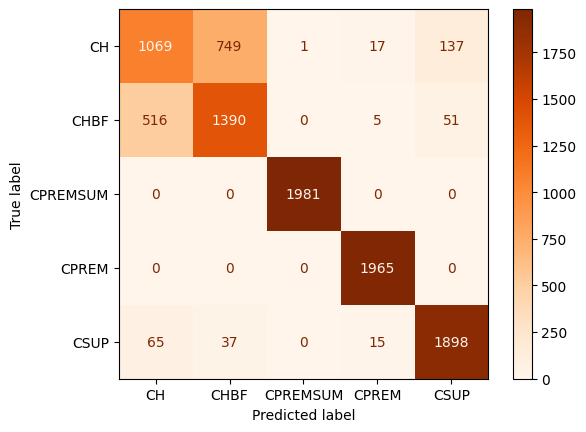

In [391]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,  roc_auc_score

y_pred = clf.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=df_labels["class_desc_short"], cmap="Oranges");

# PRUEBAS

In [394]:
df_rfm_nuevo = df_clientes_csv_rfm_with_label.join(df_rfm.drop(["class"], axis=1), how="inner")

In [402]:
df_labels

,class_desc,class_desc_short
class,,
0,clientes habituales,CH
1,clientes habituales baja frecuancia,CHBF
2,clientes premium superior,CPREMSUM
3,clientes premium,CPREM
4,clientes superior,CSUP


In [424]:
df_rfm_nuevo_temp = df_rfm_nuevo[df_rfm_nuevo["class_desc_short"]=="CSUP"]
#df_rfm_nuevo_temp = df_rfm_nuevo

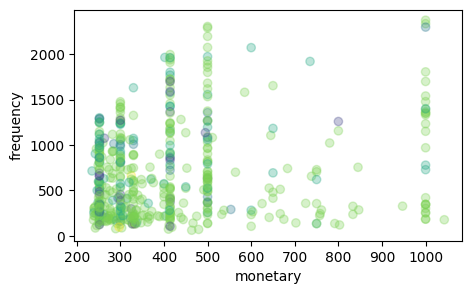

In [425]:
plot_fm_2D_cluster(df_rfm_nuevo_temp, "monetary", "frequency", df_rfm_nuevo_temp["FORMAJURIDICA"].astype('category').cat.codes)